# Các thư viện cần thiết

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import save_model


# 1. Import dữ liệu sau khi đã tổng hợp các đặc trưng

In [16]:

df_customers = pd.read_csv('./data/customer_features_final.csv', sep = ',')
df_customers

,Customer ID,Recency,Frequency,Monetary,UniqueProductCount,AvgOrderValue,ReturnRate,AvgInterpurchaseTime
0,12346.0,326,34,400.94,27,11.792353,0.0,11.969697
1,12347.0,2,222,4473.22,126,20.149640,0.0,1.805430
2,12348.0,75,51,779.73,25,15.288824,0.0,7.240000
3,12349.0,19,175,3347.99,138,19.131371,0.0,3.270115
4,12350.0,310,17,301.90,17,17.758824,0.0,0.000000
...,...,...,...,...,...,...,...,...
5876,18283.0,4,938,2631.25,352,2.805171,0.0,0.687300
5877,18284.0,432,28,374.03,28,13.358214,0.0,0.000000
5878,18285.0,661,12,229.55,12,19.129167,0.0,0.000000
5879,18286.0,477,67,1162.69,67,17.353582,0.0,3.742424


# 2. Đánh nhãn cho Returning 1/0 dựa trên Frequency đã tổng hợp

Dựa theo thống kê của cột Frequency, việc đánh nhãn sẽ dựa vào tứ phân vị thứ 1 mà quyết định khách hàng có thật sự quay lại hay không


In [17]:
threshold = df_customers['Frequency'].quantile(0.25)  # 25% phân vị

df_customers['Returning'] = df_customers['Frequency'].apply(lambda x: 1 if x >= threshold else 0)

# Xem kết quả
df_customers[['Customer ID', 'Frequency', 'Returning']].head()


,Customer ID,Frequency,Returning
0,12346.0,34,1
1,12347.0,222,1
2,12348.0,51,1
3,12349.0,175,1
4,12350.0,17,0


# 3. Chia tập train và test


In [18]:
X = df_customers.drop(columns=['Customer ID', 'Returning'])
y = df_customers['Returning']

# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
# Chuẩn hóa
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Thuật toán Hồi quy tuyến tính

In [19]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]

In [20]:
# Đánh giá
print("Logistic Regression:")
print(classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lr))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       284
           1       0.99      0.99      0.99       893

    accuracy                           0.99      1177
   macro avg       0.98      0.99      0.98      1177
weighted avg       0.99      0.99      0.99      1177

ROC AUC: 0.9988565209848114


# 5. Thuật toán Random Forest

In [21]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

In [22]:
print("\nRandom Forest:")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))


Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       284
           1       1.00      1.00      1.00       893

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177

ROC AUC: 1.0


## Nhận xét:
- Các chỉ số đánh giá về độ chính xác của 2 mô hình đều cực kỳ tốt, với độ chính xác hơn 99%
- Sự chính xác này có khả năng overfit với việc dùng Frequency làm thước đo để đánh nhãn và dùng chính frequency để train.

# 6. Chia tập Train và test với việc loại bỏ tính Frequency đi

In [23]:
x_new = df_customers.drop(columns=['Customer ID', 'Frequency', 'Returning'])
y_new = df_customers['Returning']

# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(
    x_new, y_new, test_size=0.2, stratify=y, random_state=42
)

# Chuẩn hóa đặc trưng
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# 7. Thực hiện 2 thuật toán và đánh giá độ chính xác của chúng

In [24]:
# Logistic Regression
lr = LogisticRegression(random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# Đánh giá
print("Logistic Regression:")
print(classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lr))

print("\nRandom Forest:")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       284
           1       0.99      0.99      0.99       893

    accuracy                           0.99      1177
   macro avg       0.98      0.99      0.98      1177
weighted avg       0.99      0.99      0.99      1177

ROC AUC: 0.9985607936532971

Random Forest:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       284
           1       1.00      0.99      1.00       893

    accuracy                           0.99      1177
   macro avg       0.99      0.99      0.99      1177
weighted avg       0.99      0.99      0.99      1177

ROC AUC: 0.9997634181347885


## Nhận xét:
- Sau khi bỏ đặc trưng Frequency, độ chính xác của mô hình có sự giảm nhẹ, nhưng vẫn đạt trên 99%.
- Cả 2 mô hình đều hoạt động rất tốt

# 8. Trực quan hoá trọng số của các đặc trưng trong hồi quy tuyến tính

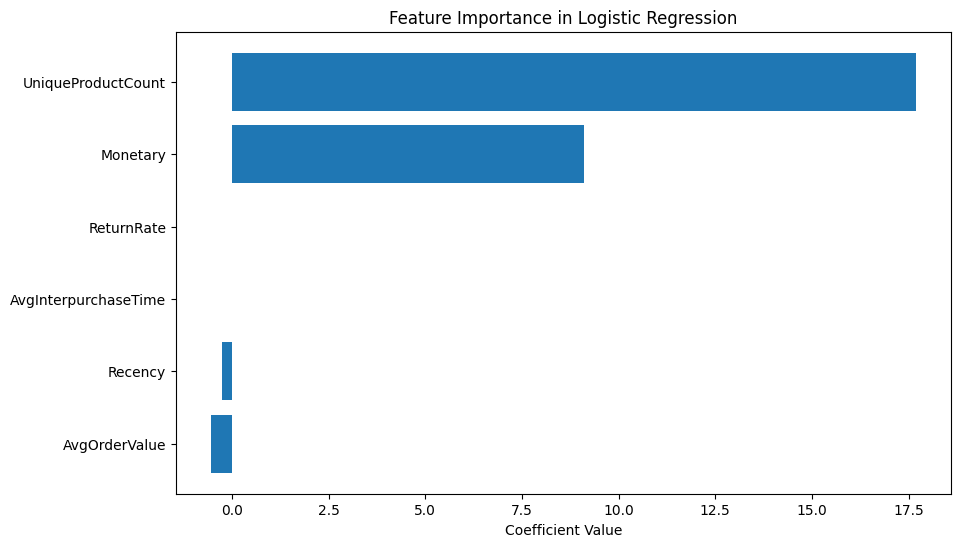

In [25]:
# Lấy tên các đặc trưng (đã loại bỏ Frequency)
feature_names = x_new.columns

# Lấy trọng số từ mô hình Logistic Regression
coefficients = lr.coef_[0]

# Tạo DataFrame để dễ dàng trực quan hóa
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': coefficients})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Trực quan hóa
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Logistic Regression')
plt.gca().invert_yaxis()  # Đảo ngược thứ tự để hiển thị từ lớn đến nhỏ
plt.show()

# 9. Xây dựng mô hình ANN để dự đoán

Epoch 1/50


C:\Users\Wall Liu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7802 - loss: 0.5400 - val_accuracy: 0.8831 - val_loss: 0.3230
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8644 - loss: 0.3207 - val_accuracy: 0.9267 - val_loss: 0.2258
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8971 - loss: 0.2475 - val_accuracy: 0.9330 - val_loss: 0.1700
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9211 - loss: 0.1919 - val_accuracy: 0.9501 - val_loss: 0.1373
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9262 - loss: 0.1680 - val_accuracy: 0.9543 - val_loss: 0.1179
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9319 - loss: 0.1526 - val_accuracy: 0.9564 - val_loss: 0.1060
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9523 - loss: 0.1244 - val_accuracy: 0.9660 - val_loss: 0.0926
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9538 - loss: 0.1125 - val_accuracy: 0.9745 - val_

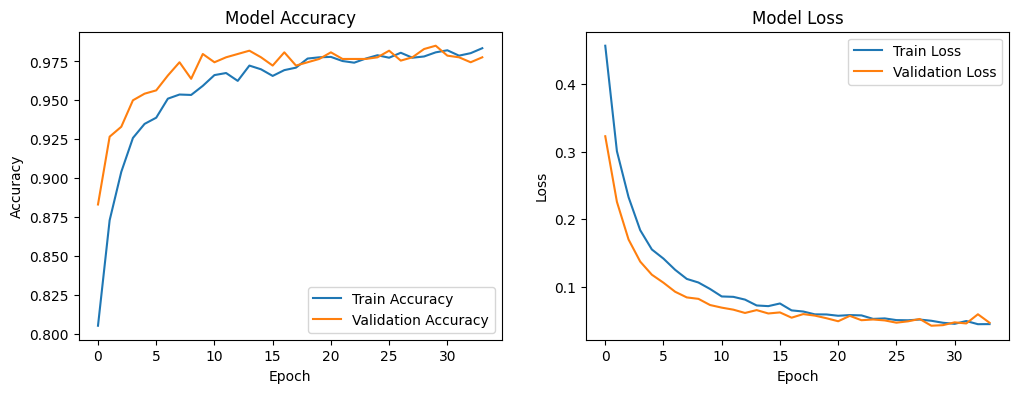

In [26]:
# Xây dựng mô hình ANN
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Biên dịch mô hình
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Early stopping để tránh overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Huấn luyện mô hình
history = model.fit(X_train_scaled, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping],
                    verbose=1)

# Đánh giá mô hình trên tập test
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\nANN Test Accuracy: {accuracy:.4f}")

# Dự đoán xác suất
y_proba_ann = model.predict(X_test_scaled).flatten()

# Tính ROC AUC
print(f"ANN ROC AUC: {roc_auc_score(y_test, y_proba_ann):.4f}")

# Vẽ đồ thị quá trình huấn luyện
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Nhận xét
## Về quá trình huấn luyện:
- Mô hình chạy được 39/50 epoch rồi dừng
- Loss và Accuracy hội tụ ở những epoch cuối
## Về độ chính xác của mô hình
- Train và Validation đề rất cao ~0.98
- Nhận định không có overfitting
## Về hàm loss
- Train và Validation đề cực thấp <0.05
- Nhận định không có underfitting
## Tổng quan
- Kết quả nhìn chung là tốt, nhưng lại quá tốt, cần kiểm tra thêm về tập dữ liệu.
- Một phần nguyên nhân do đặc trưng Frequency chứa thông tin dữ đoán, nên có sự khác biệt quá rõ ràng

# 10. Kiểm tra kết quả quá hoàn hảo có đúng hay không

In [27]:
# Kiểm tra leakage dữ liệu
assert len(set(X_train.index) & set(X_test.index)) == 0, "Data Leakage Detected!"

# Kiểm tra tính cân bằng
print("Train class ratio:", np.mean(y_train))
print("Test class ratio:", np.mean(y_test))

Train class ratio: 0.7585034013605442
Test class ratio: 0.7587085811384877


In [28]:
# Thử nghiệm với model đơn giản nhất
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression().fit(X_train_scaled, y_train)
print("LR Test Accuracy:", lr.score(X_test_scaled, y_test))

# Nếu accuracy vẫn >95% → Đặc trưng quá tốt

LR Test Accuracy: 0.9864061172472387


## Nhận xét:
- khi kiểm tra việc tập train test có bị lẫn lộn gì với nhau hay không thì kết quả 2 tập cân bằng
- khi kiểm tra lại với LR hồi quy thì kết quả vẫn tốt với tập train test
<br>$\rightarrow$ Mô hình hoạt động tốt, do đặc trưng là thuộc tính để suy ra kết quả nên độ chính xác là rất cao

# 11. Đóng gói mô hình

In [30]:
# Lưu model ANN và scaler
save_model(model, './model/returning_customer_ann.h5')
joblib.dump(scaler, './model/scaler.pkl')

['./model/scaler.pkl']